In [469]:
root = '../'

import os, sys
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd

from functools import cmp_to_key

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [566]:
# Basic settings
torch.manual_seed(470)
torch.cuda.manual_seed(470)

#!pip install easydict
from easydict import EasyDict as edict

args = edict()
args.batch_size = 2
args.nlayers = 2

args.embedding_size = 4
args.ninp = 4 + args.embedding_size
args.nhid = 256 #512


args.clip = 1
args.lr_lstm = 0.001
args.dropout = 0.2
args.nhid_attn = 256
args.epochs = 20

##### Transformer
args.nhid_tran = 256
args.nhead = 8
args.nlayers_transformer = 6
args.attn_pdrop = 0.1
args.resid_pdrop = 0.1
args.embd_pdrop = 0.1
args.nff = 4 * args.nhid_tran


args.lr_transformer = 0.0001 #1.0
args.betas = (0.9, 0.98)

args.gpu = True

args.tensorboard = False
args.train_portion = 0.7
args.slide_deck_N = 5
args.slide_deck_embedding_size = 512
args.padding_idx = 0
args.max_seq_length = 8

device = 'cuda:0' if torch.cuda.is_available() and args.gpu else 'cpu'
# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [567]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [568]:
BB_TYPES = [
    '<pad>',
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

In [569]:
def draw_bbs(shape, bbs):
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())
    if (torch.is_tensor(shape)):
        [h, w] = np.array(shape.tolist())
        shape = (h, w)
    
    h, w = shape
    fig, ax = plt.subplots(1)
    background=patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='b', facecolor='black')
    ax.add_patch(background)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.autoscale(True, 'both')
    plt.show()
    return

def get_BB_types(bbs):
    return bbs[:, 4]

class BBSlideDeckDataset(Dataset):
    """ Slide Deck Dataset but with Bounding Boxes"""
    def __init__(self, slide_deck_data, transform=None):
        self.transform = transform

        self.slide_deck_data = slide_deck_data
        self.slide_deck_ids = list(self.slide_deck_data.keys())
    
    def __len__(self):
        return len(self.slide_deck_ids)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        slide_deck_id = self.slide_deck_ids[idx]
        (h, w) = self.slide_deck_data[slide_deck_id]["shape"]
        lengths_slide_deck = []
        
        slides = []
        max_len_bbs = args.max_seq_length
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            lengths_slide_deck.append(len(slide))
            np_slide = np.zeros((max_len_bbs, 5), dtype=np.double)
            for i, bb in enumerate(slide):
                if (i > max_len_bbs):
                    break
                np_slide[i] = bb
            slides.append(np_slide)
        ref_slide = slides[0]
        slide_deck = slides[1:]
        length_ref_types = lengths_slide_deck.pop(0)
        sample = {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": get_BB_types(ref_slide),
            "slide_deck": np.asarray(slide_deck),
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

        if self.transform:
            sample = self.transform(sample)
        return sample


In [570]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)
            lengths_slide_deck = lengths_slide_deck[:self.N]

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        lengths_slide_deck.append(length_ref_types)
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))

        idxs = np.array([*range(0, len(lengths_slide_deck))], dtype=np.int32)
        np.random.shuffle(idxs)

        slide_deck = slide_deck[idxs]

        lengths_slide_deck = np.array(lengths_slide_deck, dtype=np.int32)
        lengths_slide_deck = lengths_slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck.tolist()
        
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        length_ref_types = lengths_slide_deck.pop()
        ref_types = get_BB_types(ref_slide)

        slide_deck = np.asarray(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        idxs = [*range(0, len(lengths_slide_deck))]

        def by_length(p1, p2):
            return lengths_slide_deck[p2] - lengths_slide_deck[p1]
        idxs = sorted(idxs, key=cmp_to_key(by_length))

        shape = torch.tensor([h, w], dtype=torch.float64)
        ref_slide = torch.from_numpy(ref_slide).float()
        ref_types = torch.from_numpy(ref_types).float()
        
        slide_deck = torch.from_numpy(slide_deck).float()
        lengths_slide_deck = torch.tensor(lengths_slide_deck, dtype=torch.int32)
        
        slide_deck = slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck[idxs]

        length_ref_types = torch.tensor(length_ref_types, dtype=torch.int32)

        return {
            "shape": shape,
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types
        }

In [571]:
def process_slide_deck_dataset(all_dataset):
    slide_deck_data = {}
    for entrance in all_dataset.iloc:
        slide_deck_id = entrance['Slide Deck Id']
        
        slide_id = entrance["Slide Id"]
        if (slide_deck_id not in slide_deck_data):
            slide_deck_data[slide_deck_id] = {
                'slides': {},
                'shape': (entrance['Image Height'], entrance['Image Width'])
            }
        
        if slide_id not in slide_deck_data[slide_deck_id]["slides"]:
            slide_deck_data[slide_deck_id]["slides"][slide_id] = []
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type
        ]).T
        slide_deck_data[slide_deck_id]['slides'][slide_id].append(bb)
    for key in slide_deck_data.keys():
        
        # if key == 100:
        #     for (id, value) in slide_deck_data[key]["slides"].items():
        #         print(56, id)
        #         draw_bbs(slide_deck_data[key]["shape"], value)

        values = list(slide_deck_data[key]["slides"].values())
        slide_deck_data[key]["slides"] = [np.asarray(value) for value in values]
    return slide_deck_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [572]:
csv_file = os.path.join(os.path.dirname(os.getcwd()), "data", "slide_deck_dataset.csv")

dataset = pd.read_csv(csv_file)
slide_deck_data = process_slide_deck_dataset(dataset)

division = int(args.train_portion * len(slide_deck_data))

train_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, 0, division),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)

test_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, division, len(slide_deck_data)),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)


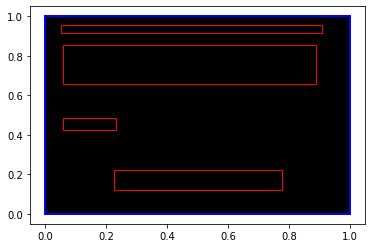

tensor([1., 3., 9., 3., 0., 0., 0., 0.])
tensor([[0.1180, 0.1210, 0.7664, 0.1064, 1.0000],
        [0.0892, 0.3256, 0.8113, 0.0670, 3.0000],
        [0.0915, 0.5126, 0.5762, 0.0640, 3.0000],
        [0.0930, 0.4284, 0.5611, 0.0625, 3.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0836, 0.3241, 0.7977, 0.3261, 3.0000],
        [0.2242, 0.1174, 0.5539, 0.1089, 1.0000],
        [0.0858, 0.7364, 0.6900, 0.0776, 3.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0824, 0.6295, 0.7762, 0.1028, 3.0000],
        [0.0711, 0.2939, 0.8537, 0.2132, 3.0000],
        [0.3043, 0.1210, 0.3898, 0.0867, 1.0000],
       

In [573]:
single = train_slide_deck_dataset[0]
draw_bbs(single["shape"], single["ref_slide"])

print(single["ref_types"])
for i in range(5):
    print(single["slide_deck"][i])
print(single["lengths_slide_deck"])

In [574]:
train_loader = DataLoader(train_slide_deck_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_slide_deck_dataset, batch_size=args.batch_size, shuffle=True)


In [575]:
class SlideEncoder(nn.Module):
    def __init__(self):
        super(SlideEncoder, self).__init__()
        ninp = args.ninp
        nhid = args.nhid
        nlayers = args.nlayers
        dropout = args.dropout
        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, args.padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(ninp, nhid, nlayers, bias=True).float()

    def forward(self, x, states, lengths=None):
        """
        Args:
            x: tensor(B, L, 5)
            states: List[Tuple(h_0, c_0), ..., Tuple(h_{B-1}, c_{B-1})]
            lengths: tensor(B)
        """
        idxs = [*range(0, len(lengths))]
        def by_lengths(p1, p2):
            return lengths[p2] - lengths[p1]

        idxs = sorted(idxs, key=cmp_to_key(by_lengths))

        x = x[:, idxs]
        lengths = lengths[idxs]
        
        input = x[:, :, :-1]
        types = x[:, :, -1:].long()
        types = torch.squeeze(self.embed(types))
        input = torch.cat((input, types), dim=-1)

        output = self.dropout(input)
        

        output = torch.nn.utils.rnn.pack_padded_sequence(output, lengths)

        h_0 = torch.stack([h for (h, _) in states], dim=0)
        c_0 = torch.stack([c for (_, c) in states], dim=0)
        
        (output, context_vector) = self.lstm(output, (h_0, c_0))
        output, lengths = torch.nn.utils.rnn.pad_packed_sequence(output, total_length = args.max_seq_length)
        return (output, context_vector)

class SlideDeckEncoder(nn.Module):
    def __init__(self):
        super(SlideDeckEncoder, self).__init__()
        self.slide_encoder = SlideEncoder()

        input_size = args.nhid * args.slide_deck_N
        output_size = args.slide_deck_embedding_size

        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        return

    def _get_init_states(self, x):
        init_states = [
            (torch.zeros((x.size(1), args.nhid)).to(x.device),
            torch.zeros((x.size(1), args.nhid)).to(x.device))
            for _ in range(args.nlayers)
        ]
        return init_states
    
    def forward(self, xs, lengths):
        states = None
        embedding = []
        for i, x in enumerate(xs):
            if states is None:
                states = self._get_init_states(x)
            length = lengths[i]
            output, states = self.slide_encoder(x, states, length)
            output = output[length.long() - 1,:,:]
            idxs = torch.arange(args.batch_size)
            output = output[idxs, idxs, :]
            embedding.append(output[-1:].squeeze())
        
        output = torch.cat(embedding, dim=-1)
        output = self.relu(self.linear(output))
        return output

In [577]:
model = SlideDeckEncoder().to(device)

for epoch in range(args.epochs):
    for batch in train_loader:
        xs = torch.transpose(batch["slide_deck"], 0, 1)
        xs = torch.transpose(xs, 1, 2)
        lengths = torch.transpose(batch["lengths_slide_deck"], 0, 1)
        slide_deck_embedding = model(xs, lengths)
